Generating KDEs: 100%|██████████████████████████| 28/28 [01:02<00:00,  2.22s/it]


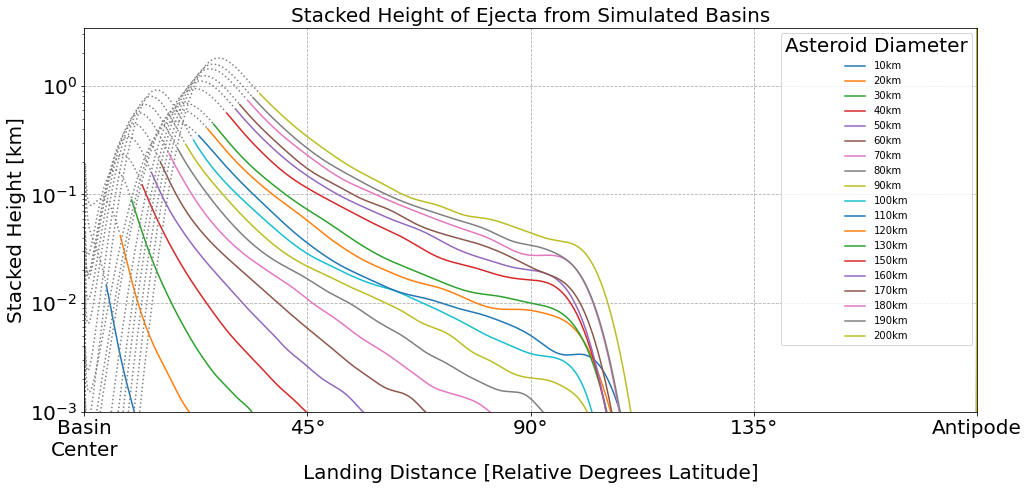

Interpolating Data: 100%|███████████████████████| 19/19 [01:41<00:00,  5.34s/it]

COMPLETED


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from KDEpy import NaiveKDE, FFTKDE
import scipy.interpolate as interp
import scipy.integrate as integrate
from function_library_3 import extract,asteroid_diameter,scaling_law,Silverman
from tqdm import tqdm

#================================================================================
# SETUP

#change default font size for graphs
plt.rcParams.update({'font.size':20})

# create the needed directories and clear old output
import os,glob
try:
    os.mkdir('1_KDE_Data')
except:
    for filename in glob.glob('1_KDE_Data/*'):
        os.remove(filename)
        
try:
    os.mkdir('2_Stacked_List')
except:
    for filename in glob.glob('2_Stacked_List/*'):
        os.remove(filename)
try:
    os.mkdir('2_Basin_Pressures')
except:
    for filename in glob.glob('2_Basin_Pressures/*'):
        os.remove(filename)
try:
    os.mkdir('2_Basin_Temperatures')
except:
    for filename in glob.glob('2_Basin_Temperatures/*'):
        os.remove(filename)

#================================================================================
# GENERATE STACKED HEIGHT DISTRIBUTIONS AND KDEs

fig = plt.figure(figsize=[16,24],facecolor='white')   
ax1 = fig.add_subplot(311)
ax1.set_title("Stacked Height of Ejecta from Simulated Basins", fontsize=20)
        
sim_list = []
size_list = []
for filename in os.listdir('0_Prime_Data'):
    if filename.endswith(".dat"):
        sim_list.append(filename)
        size_list.append(asteroid_diameter('0_Prime_Data/'+filename))
                                           
size_list, sim_list = zip(*sorted(zip(size_list, sim_list)))

R_p = 1750

Asteroid_List = []
Stacked_List = []
KDE_List_p = []
KDE_List_T = []
KDE2D_List_zp = []
KDE2D_List_zT = []
KDE2D_List_Zp = []
KDE2D_List_ZT = []

x_range = [1,np.pi*R_p]
p_range = [.1,310]
T_range = [200,14000]

grid_points0 = 2**10

XS = np.linspace(x_range[0],x_range[1],grid_points0)
PS = np.linspace(p_range[0],p_range[1],grid_points0)
TS = np.linspace(T_range[0],T_range[1],grid_points0)

grid_points = 2**10

XS_log = np.linspace(np.log(x_range[0]),np.log(x_range[1]),grid_points)
PS1 = np.linspace(p_range[0],p_range[1],grid_points)
TS1 = np.linspace(T_range[0],T_range[1],grid_points)

grid_p = []
grid_T = []

height_x = list(XS)
x = None
X = None

for i in range(grid_points):
    for j in range(grid_points):
        grid_p.append([XS_log[i],PS1[j]])
        grid_T.append([XS_log[i],TS1[j]])

grid_p = np.array(grid_p)
grid_T = np.array(grid_T)

first_loop = True

for sim in tqdm(sim_list, desc = 'Generating KDEs'):
    
    # open tracer file
    file0    = open('0_Prime_Data/{}'.format(sim),'r')
    time_0, time_f, save_step, R_p, M_p, R_imp, v_imp, coords, R_c = eval(file0.readline().replace('\n',''))
    used = extract(file0)
    material = extract(file0)
    volume   = extract(file0)
    spread   = extract(file0)
    mass     = extract(file0)
    launch_time     = extract(file0)
    launch_polar    = extract(file0)
    launch_length   = extract(file0)
    launch_height   = extract(file0)
    launch_velocity = extract(file0)
    launch_angle    = extract(file0)
    pressure    = extract(file0)
    temperature = extract(file0)
    landing_time   = extract(file0)
    landing_polar  = extract(file0)
    landing_length = extract(file0)
    max_altitude   = extract(file0)
    file0.close()   
    
    N,E = coords
    
    weight_choice = volume
    
    # Accumulated Height (Weight must be volume for this to work)
    height_prime = NaiveKDE(kernel='gaussian', bw='silverman').fit(landing_length,weights=volume).evaluate(grid_points=XS)
    height_val = [1e-16]
    total_volume = sum(volume)
    for i in range(1,len(XS)):
        height_val.append(height_prime[i]*total_volume/(XS[i]-XS[i-1])/(2*np.pi*R_p*np.sin(XS[i]/R_p)))
    
    Asteroid_List.append(R_imp)
    Stacked_List.append(height_val)
    
    R_c = scaling_law(2*R_imp)/2
    
    for i in range(len(XS)):
        if XS[i] > R_c:
            break
    if (2*R_imp % 10) != 4:
        ax1.plot(XS[:i],height_val[:i],ls=':',c='grey')
        ax1.plot(XS[i:],height_val[i:],label=sim.replace('.dat',''))
        
    #======================================================================================================
    
    weight_choice = volume
    
    # Pressures
    pressure_val = NaiveKDE(kernel='gaussian', bw='silverman').fit(pressure,weights=weight_choice).evaluate(PS)
    KDE_List_p.append(pressure_val)

    # Temperature
    temperature_val = NaiveKDE(kernel='gaussian', bw='silverman').fit(temperature,weights=weight_choice).evaluate(TS)
    KDE_List_T.append(temperature_val)

    
    #2D KDE
    data0 = np.array([np.log(abs(landing_length)),pressure])
    land_pres_log=np.transpose(data0) # log data of pressure and landing location
    data0 = np.array([np.log(abs(landing_length)),temperature])
    land_temp_log=np.transpose(data0) # log data of temperature and landing location

    # Compute the kernel density estimate
    h_landing = Silverman(np.log(abs(landing_length)))
    h_pressure = Silverman(pressure)
    h_temperature = Silverman(temperature)
    kdep = FFTKDE(kernel='gaussian', bw=(h_landing,h_pressure))
    points_p = kdep.fit(land_pres_log, weights=weight_choice).evaluate(grid_p) 
    kdeT = FFTKDE(kernel='gaussian', bw=(h_landing,h_temperature))
    points_T = kdeT.fit(land_temp_log, weights=weight_choice).evaluate(grid_T)
    

    # Generate the 2D grid of points and their Z values
    Xp_log, Yp = np.unique(grid_p[:, 0]), np.unique(grid_p[:, 1])
    X_ = np.exp(Xp_log) 
    Zp = points_p.reshape(grid_points, grid_points).T
    XT_log, YT = np.unique(grid_T[:, 0]), np.unique(grid_T[:, 1])
    ZT = points_T.reshape(grid_points, grid_points).T 
    
    # change the mesh into three lists of xyz coordinates
    Total_Volume = float(np.sum(volume)) # scale by the total volume of material
    x_ = [] # get x coordinates
    number = len(X_)
    for i in range(number):
        for each in X_:
            x_.append(each) 
    # get y and z coords
    yp,zp=[],[] ; yT,zT=[],[]   
    for each in Yp:
        for i in range(number):
            yp.append(each)   
    for each in Zp:
        for every in each:
            zp.append(every*Total_Volume)   
    for each in YT:
        for i in range(number):
            yT.append(each)   
    for each in ZT:
        for every in each:
            zT.append(every*Total_Volume)
            
    if first_loop: # the x values will always be the same grid for every sim
        X = X_
        x = x_
        first_loop = False
        
    # Generate lists of all the 2D KDE data
            
    KDE2D_List_zp.append(zp)
    KDE2D_List_zT.append(zT)
    KDE2D_List_Zp.append(Zp*Total_Volume)
    KDE2D_List_ZT.append(ZT*Total_Volume)
    
    
ax1.set_xlim(0,np.pi*R_p)
ax1.set_ylim(bottom=10e-4,top=3.4)
ax1.set_yscale('log')
ax1.set_xlabel('Landing Distance [Relative Degrees Latitude]')
ax1.set_ylabel('Stacked Height [km]')
ax1.grid(True, ls='--', zorder=-15); plt.legend(title='Asteroid Diameter',fontsize=10);
plt.xticks([0,R_p*np.pi/4,R_p*np.pi/2,3*R_p*np.pi/4, R_p*np.pi],labels=['Basin\nCenter','45°','90°','135°','Antipode'])
plt.show()

#================================================================================
# CREATE FUNCTION THAT EXTRACTS DATA FROM EACH BASIN

def data_extract(basin):
    # open tracer file
    file0    = open('1_Basin_Data/{}.dat'.format(basin),'r')
    time_0, time_f, save_step, R_p, M_p, R_imp, v_imp, coords, R_c = eval(file0.readline().replace('\n',''))
    used = extract(file0)
    material = extract(file0)
    volume   = extract(file0)
    spread   = extract(file0)
    mass     = extract(file0)
    launch_time     = extract(file0)
    launch_polar    = extract(file0)
    launch_length   = extract(file0)
    launch_height   = extract(file0)
    launch_velocity = extract(file0)
    launch_angle    = extract(file0)
    pressure    = extract(file0)
    temperature = extract(file0)
    landing_time   = extract(file0)
    landing_polar  = extract(file0)
    landing_length = extract(file0)
    max_altitude   = extract(file0)
    file0.close() 
    
    weight_choice = volume
    
    N,E = coords
    
    if R_imp < Asteroid_List[0]:
        height_val      = Stacked_List[0]
        pressure_val    = KDE_List_p[0]
        temperature_val = KDE_List_T[0]
        zp = KDE2D_List_zp[0]
        zT = KDE2D_List_zT[0]
        Zp = KDE2D_List_Zp[0]
        ZT = KDE2D_List_ZT[0]
                    
    elif R_imp > Asteroid_List[-1]:
        height_val      = Stacked_List[-1]
        pressure_val    = KDE_List_p[-1]
        temperature_val = KDE_List_T[-1]
        zp = KDE2D_List_zp[-1]
        zT = KDE2D_List_zT[-1]
        Zp = KDE2D_List_Zp[-1]
        ZT = KDE2D_List_ZT[-1]
        
    else:
        for i in range(len(Asteroid_List)):
            if Asteroid_List[i] < R_imp and R_imp < Asteroid_List[i+1]:
                
                lower_ratio = (R_imp - Asteroid_List[i])/(Asteroid_List[i+1]-Asteroid_List[i])
                upper_ratio = (Asteroid_List[i+1] - R_imp)/(Asteroid_List[i+1]-Asteroid_List[i])
                
                height_val      = list(lower_ratio*np.array(Stacked_List[i+1]) + upper_ratio*np.array(Stacked_List[i]))
                pressure_val    = list(lower_ratio*np.array(KDE_List_p[i+1]) + upper_ratio*np.array(KDE_List_p[i]))
                temperature_val = list(lower_ratio*np.array(KDE_List_T[i+1]) + upper_ratio*np.array(KDE_List_T[i]))
                zp = list(lower_ratio*np.array(KDE2D_List_zp[i+1]) + upper_ratio*np.array(KDE2D_List_zp[i]))
                zT = list(lower_ratio*np.array(KDE2D_List_zT[i+1]) + upper_ratio*np.array(KDE2D_List_zT[i]))
                Zp = lower_ratio*np.array(KDE2D_List_Zp[i+1]) + upper_ratio*np.array(KDE2D_List_Zp[i])
                ZT = lower_ratio*np.array(KDE2D_List_ZT[i+1]) + upper_ratio*np.array(KDE2D_List_ZT[i])
                
                break     
    
    #-----------------------------------------------
    #            Graph the Basin Data
    #-----------------------------------------------
    
    # Stacked Height
    fig = plt.figure(figsize=[16,8],facecolor='white')
    plt.suptitle("{}".format(basin), fontsize=32)
    plt.title('Stacked Height of Ejecta from Basin Center to Antipode')
    plt.plot(height_x,height_val,label='Stacked Height')
    plt.xlabel('\nLanding Location')
    plt.xlim(0,np.pi*R_p)
    plt.xticks([R_c,0,R_p*np.pi/4,R_p*np.pi/2,3*R_p*np.pi/4, R_p*np.pi],labels=['\nEdge','Center','45°','90°','135°','Antipode'])
    plt.ylabel('Height [km]')
    plt.ylim(bottom=5e-7)
    plt.yscale('log') 
    plt.grid(True, ls='--', zorder=-15); plt.legend();
    fig.savefig('2_Stacked_List/Stacked Height of {}'.format(basin))
    plt.close(fig)   
    
    #-----------------------------------------------
    
    # Pressure Histogram
    fig = plt.figure(figsize=[16,8],facecolor='white')
    plt.suptitle("{}".format(basin), fontsize=32)
    plt.title('Peak Pressure Distribition')
    plt.hist(pressure, bins = 500, alpha=.2, weights=weight_choice, density=True)
    plt.plot(PS,pressure_val, label='KDE')
    plt.xlabel('Pressure [GPa]')
    plt.ylabel('Probability Density')
    plt.xlim(0,150)
    plt.grid(True, ls='--', zorder=-15); plt.legend(); 
    fig.savefig('2_Basin_Pressures/Pressure Distribution of {}'.format(basin))
    plt.close(fig)
    
    # Temperature Histogram
    fig = plt.figure(figsize=[16,8],facecolor='white')
    plt.suptitle("{}".format(basin), fontsize=32)
    plt.title('Peak Temperature Distribition')
    plt.hist(temperature, bins = 500, alpha=.2, weights=weight_choice, density=True)
    plt.plot(TS,temperature_val, label='KDE')
    plt.xlabel('Temperature [K]')
    plt.ylabel('Probability Density')
    plt.xlim(250,3000)
    plt.grid(True, ls='--', zorder=-15); plt.legend(); 
    fig.savefig('2_Basin_Temperatures/Temperature Distribution of {}'.format(basin))
    plt.close(fig)
    
    #-----------------------------------------------
    # (  These graphs can be very slow if grid_points are set sufficiently high (> 2**7)  )
    
    # Pressure 2D KDE
    fig = plt.figure(figsize=[16,8],facecolor='white')
    plt.suptitle("{}".format(basin), fontsize=32)
    plt.title('Peak Pressure vs Landing Location PDF')
    plt.pcolormesh(X, Yp, Zp, cmap="viridis",shading='auto')
    plt.xlabel('\nLanding Location') 
    plt.xlim(90,np.pi*R_p)
    plt.xscale('log') 
    plt.xticks([R_c,100,R_p*np.pi/4,R_p*np.pi/2, R_p*np.pi],labels=['\nEdge','100km','45°','90°','Antipode'])
    plt.ylabel('Pressure [GPa]')
    plt.ylim(1,30)
    plt.colorbar(label='Abundance [km GPa]')
    fig.savefig('2_Basin_Pressures/Pressure 2D KDE of {}'.format(basin))
    plt.close(fig)
    
    # Temperature 2D KDE
    fig = plt.figure(figsize=[16,8],facecolor='white')
    plt.suptitle("{}".format(basin), fontsize=32)
    plt.title('Peak Temperature vs Landing Location PDF')
    plt.pcolormesh(X, YT, ZT, cmap="viridis",shading='auto')
    plt.xlabel('\nLanding Location') 
    plt.xlim(90,np.pi*R_p)
    plt.xscale('log') 
    plt.xticks([R_c,100,R_p*np.pi/4,R_p*np.pi/2, R_p*np.pi],labels=['\nEdge','100km','45°','90°','Antipode'])
    plt.ylabel('Temperature [K]')
    plt.ylim(190,2000)
    plt.colorbar(label='Abundance [km K]')
    fig.savefig('2_Basin_Temperatures/Temperature 2D KDE of {}'.format(basin))
    plt.close(fig)
    
    return [basin, x, yp,zp, yT,zT, height_x, height_val, coords, R_p, R_c]
    
#================================================================================
# CREATE MAIN FUNCTION 

def data_prime():

    basin_list = [] # generate a list of the included basins
    for filename in os.listdir('1_Basin_Data'):
        if filename.endswith(".dat"):
            basin_list.append(filename[:-4])
            
    basin_list.sort() # alphabatize the basins
        
    # make output files for each basin
    for basin in tqdm(basin_list, desc = 'Interpolating Data'):
        #print(basin)
        KDEfile = open('1_KDE_Data/{}.dat'.format(basin),'a')
        KDEfile.write(str(list(data_extract(basin))))  
        KDEfile.close()

#================================================================================
# RUN MAIN FUNCTION 

data_prime()

print('COMPLETED')
